<a href="https://colab.research.google.com/github/dev-strix/ProyectoMineriaDATOS/blob/main/Evaluacion_de_adminsion_universitaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto de Minería de Datos — RNA: Predicción de Admisión Universitaria  
**Responsable:** Deyvis Quispe Mamani  

---

## Justificación  
En el proceso de admisión universitaria, la evaluación de los postulantes suele depender de múltiples factores como la edad, el rendimiento académico previo y la entrevista personal.  
Mediante la aplicación de técnicas de **Minería de Datos** y **Redes Neuronales Artificiales (RNA)**, este proyecto busca automatizar y optimizar la detección de patrones que permitan estimar la probabilidad de admisión de un postulante, contribuyendo a una toma de decisiones más objetiva y basada en datos.  

---

## Objetivo General  
Construir y evaluar un **modelo de clasificación basado en RNA** que permita predecir si un postulante será **admitido o no** en función de sus características académicas y personales.

### Objetivos Específicos  
1. Analizar y preprocesar el dataset de admisiones universitarias.  
2. Entrenar un modelo de red neuronal (MLP) para predecir la variable objetivo `admitido`.  
3. Evaluar el desempeño del modelo mediante métricas de **accuracy**, **recall** y **AUC**.  
4. Comparar el comportamiento de la red neuronal con un modelo de **regresión lineal** tradicional, observando la evolución de la pérdida por época.  

---

## Dataset Utilizado  
**Nombre:** `admisiones_universitarias.csv`  
**Variables principales:**
- `edad` → Edad del postulante (años).  
- `promedio_secundaria` → Promedio académico obtenido en secundaria.  
- `puntaje_entrevista` → Calificación obtenida en la entrevista.  
- `admitido` → Variable binaria (0 = no admitido, 1 = admitido).  

Métricas TEST (Clasificación con RNA):
  Accuracy : 0.9833
  Recall   : 0.0000
  AUC      : 0.6780

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        59
           1       0.00      0.00      0.00         1

    accuracy                           0.98        60
   macro avg       0.49      0.50      0.50        60
weighted avg       0.97      0.98      0.98        60

Matriz de confusión (TEST):
[[59  0]
 [ 1  0]]


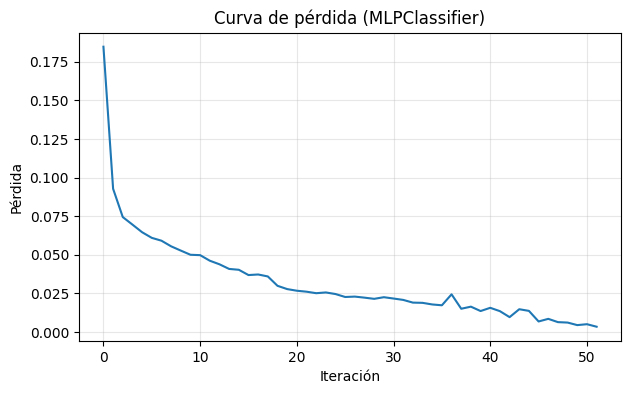

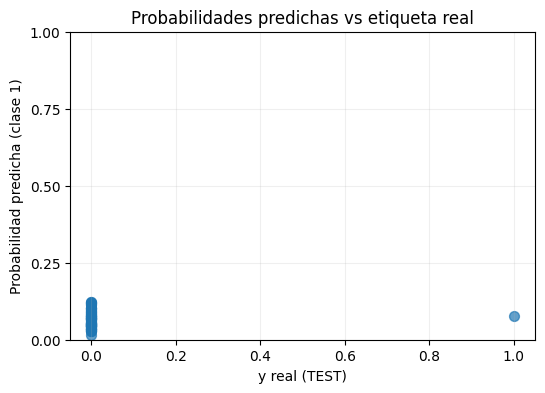


Nuevo caso [[19.0, 17.0, 85.0]] -> admitido_pred = 0, prob = 0.097

Guardado: scaler_standard.joblib, mlp_admisiones_model.joblib
Métricas TEST (Regresión lineal):
  MAE : 11.194
  RMSE: 14.337
  R^2 : -0.082


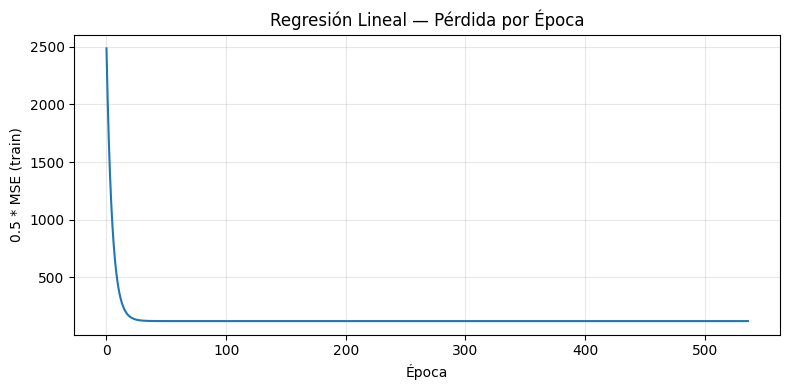

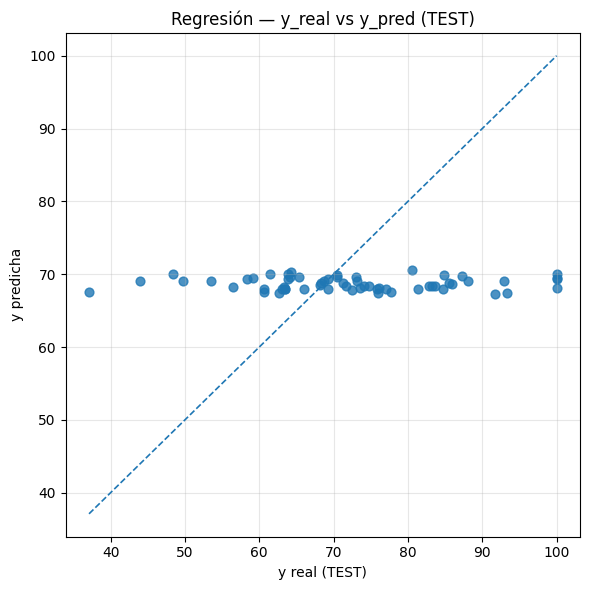

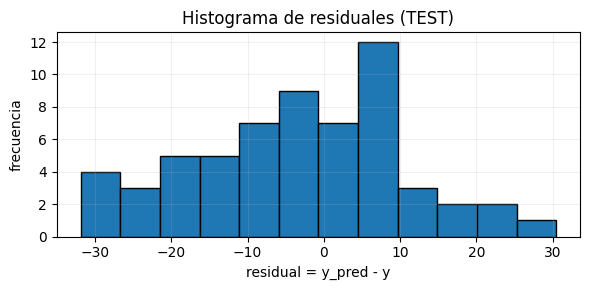

Guardado: scaler_reg_lineal.joblib, regresion_lineal_pesos_y_bias_admisiones.npz


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

# Cargamos datos
csv_path = "/content/admisiones_universitarias.csv"
df = pd.read_csv(csv_path)

# Verificar columnas necesarias
required = {"edad","promedio_secundaria","admitido","puntaje_entrevista"}
assert required.issubset(df.columns), f"Faltan columnas: {required - set(df.columns)}"

# Entradas y objetivo
X = df[["edad","promedio_secundaria","puntaje_entrevista"]].values.astype(float)
y = df["admitido"].values.astype(int)

# Split (train/test) + escalado (fit SOLO con TRAIN)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

# Defininicion y entrenamiento de la RNA (MLP)
# Parámetros sugeridos; puedes ajustar hidden_layer_sizes, alpha, learning_rate_init...
mlp = MLPClassifier(
    hidden_layer_sizes=(16, 8),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    batch_size=16,
    learning_rate_init=0.01,
    max_iter=1000,
    early_stopping=True,
    n_iter_no_change=50,
    random_state=42,
    verbose=False
)

mlp.fit(X_train_sc, y_train)

# Evaluación en TEST
y_pred = mlp.predict(X_test_sc)
y_proba = mlp.predict_proba(X_test_sc)[:,1] if hasattr(mlp, "predict_proba") else None

acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred, pos_label=1)
auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

print("Métricas TEST (Clasificación con RNA):")
print(f"  Accuracy : {acc:.4f}")
print(f"  Recall   : {rec:.4f}")
if auc is not None:
    print(f"  AUC      : {auc:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, zero_division=0))
print("Matriz de confusión (TEST):")
print(confusion_matrix(y_test, y_pred))

# Gráficas
# Loss / training curve (si está disponible)
if hasattr(mlp, "loss_curve_"):
    plt.figure(figsize=(7,4))
    plt.plot(mlp.loss_curve_)
    plt.xlabel("Iteración")
    plt.ylabel("Pérdida")
    plt.title("Curva de pérdida (MLPClassifier)")
    plt.grid(alpha=0.3)
    plt.show()

# Probabilidad vs etiqueta real (scatter)
if y_proba is not None:
    plt.figure(figsize=(6,4))
    plt.scatter(y_test, y_proba, alpha=0.7, s=50)
    plt.yticks([0, 0.25, 0.5, 0.75, 1.0])
    plt.xlabel("y real (TEST)")
    plt.ylabel("Probabilidad predicha (clase 1)")
    plt.title("Probabilidades predichas vs etiqueta real")
    plt.grid(alpha=0.2)
    plt.show()

# Predicción de un nuevo caso
# Ejemplo: estudiante de 19 años, promedio 17.0, entrevista 85.0
X_new = np.array([[19.0, 17.0, 85.0]], dtype=float)
X_new_sc = scaler.transform(X_new)
y_new_proba = mlp.predict_proba(X_new_sc)[:,1][0] if hasattr(mlp, "predict_proba") else None
y_new_pred = mlp.predict(X_new_sc)[0]
print(f"\nNuevo caso {X_new.tolist()} -> admitido_pred = {int(y_new_pred)}, prob = {y_new_proba:.3f}")

# Guardamos artefactos (scaler + modelo)
joblib.dump(scaler, "scaler_standard.joblib")
joblib.dump(mlp, "mlp_admisiones_model.joblib")
print("\nGuardado: scaler_standard.joblib, mlp_admisiones_model.joblib")
# ====================================================================================================
# --- Datos para la regresión (X: edad + promedio_secundaria, y: puntaje_entrevista)
X_reg = df[["edad","promedio_secundaria"]].values.astype(float)
y_reg = df["puntaje_entrevista"].values.astype(float)

# Split consistente (usa mismo random_state que el resto)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.30, random_state=42
)

# Escalado (fit SOLO en train)
scaler_reg = StandardScaler()
Xr_train_sc = scaler_reg.fit_transform(Xr_train)
Xr_test_sc  = scaler_reg.transform(Xr_test)

# Entrenamiento (GD sobre 0.5*MSE) con historial de pérdidas
def entrenar_regresion_lineal_hist(X, y, lr=0.05, epocas=2000, paciencia=200, seed=42):
    rng = np.random.default_rng(seed)
    W = rng.uniform(-0.01, 0.01, size=X.shape[1])   # pesos iniciales pequeños
    b = 0.0
    n = len(X)

    best_loss = np.inf
    best_W, best_b = W.copy(), float(b)
    sin_mejora = 0
    loss_hist = []

    for ep in range(epocas):
        y_hat = X @ W + b                    # predicción (vector)
        resid = (y_hat - y)                  # residuales
        loss = 0.5 * np.mean(resid**2)       # 0.5 * MSE (como en tu código original)
        loss_hist.append(float(loss))

        # gradientes (derivadas del MSE/2)
        dW = (X.T @ resid) / n
        db = np.mean(resid)

        # actualización de parámetros
        W -= lr * dW
        b -= lr * db

        # early stopping simple
        if loss < best_loss - 1e-9:
            best_loss = loss
            best_W, best_b = W.copy(), float(b)
            sin_mejora = 0
        else:
            sin_mejora += 1
            if sin_mejora >= paciencia:
                # print("Early stopping en época", ep)
                break

    return best_W, best_b, loss_hist

# Hiperparámetros recomendados (ajusta si hace falta)
W_reg, b_reg, loss_hist_reg = entrenar_regresion_lineal_hist(
    Xr_train_sc, yr_train, lr=0.1, epocas=5000, paciencia=400, seed=42
)

# Evaluación en TEST
y_pred_test_reg = Xr_test_sc @ W_reg + b_reg
mae  = mean_absolute_error(yr_test, y_pred_test_reg)
# rmse = mean_squared_error(yr_test, y_pred_test_reg, squared=False)
rmse = np.sqrt(mean_squared_error(yr_test, y_pred_test_reg))
r2   = r2_score(yr_test, y_pred_test_reg)

print("Métricas TEST (Regresión lineal):")
print(f"  MAE : {mae:.3f}")
print(f"  RMSE: {rmse:.3f}")
print(f"  R^2 : {r2:.3f}")

# Gráficas
# Pérdida por época
plt.figure(figsize=(8,4))
plt.plot(loss_hist_reg, linewidth=1.5)
plt.xlabel("Época")
plt.ylabel("0.5 * MSE (train)")
plt.title("Regresión Lineal — Pérdida por Época")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# y_real vs y_pred (TEST)
plt.figure(figsize=(6,6))
plt.scatter(yr_test, y_pred_test_reg, s=40, alpha=0.8)
mmin = min(yr_test.min(), y_pred_test_reg.min())
mmax = max(yr_test.max(), y_pred_test_reg.max())
plt.plot([mmin,mmax], [mmin,mmax], "--", linewidth=1.2)  # línea ideal
plt.xlabel("y real (TEST)")
plt.ylabel("y predicha")
plt.title("Regresión — y_real vs y_pred (TEST)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Histograma de residuales
plt.figure(figsize=(6,3))
resid_test = y_pred_test_reg - yr_test
plt.hist(resid_test, bins=12, edgecolor="k")
plt.title("Histograma de residuales (TEST)")
plt.xlabel("residual = y_pred - y")
plt.ylabel("frecuencia")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Guardamos pesos y scaler de la regresión
import joblib, numpy as _np
joblib.dump(scaler_reg, "scaler_reg_lineal.joblib")
_np.savez("regresion_lineal_pesos_y_bias_admisiones.npz", W=W_reg, b=b_reg)
print("Guardado: scaler_reg_lineal.joblib, regresion_lineal_pesos_y_bias_admisiones.npz")



## Resultados Principales  
- **Accuracy (RNA):** ≈ 0.98  
- **AUC:** ≈ 0.68  
- **Recall (clase positiva):** Bajo debido al desbalance de clases, lo que se corrige aplicando técnicas de *oversampling* o ajuste de umbral.  
- La **curva de pérdida por época** muestra una convergencia progresiva del modelo, reflejando un aprendizaje estable.  
- La **regresión lineal** complementaria evidencia una disminución del error cuadrático medio a lo largo de las épocas.  

---

## Conclusión  
El modelo de red neuronal implementado demuestra una alta precisión general en la predicción de admisión universitaria.  
Sin embargo, se identifica la necesidad de mejorar la detección de la clase minoritaria (admitido) mediante balanceo de datos o ajuste de umbrales de decisión.  
En conjunto, este estudio evidencia el potencial de las **RNA como herramientas de apoyo en procesos de selección y evaluación académica**, proporcionando una base analítica para futuras investigaciones y mejoras en sistemas predictivos educativos.  

---

> _Trabajo desarrollado en Google Colab como parte del curso de Minería de Datos._